#(1) Import Python Libraries

In [99]:
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential  # initial NN
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, InputLayer, BatchNormalization # construct each layer
from tensorflow.keras.layers import Conv2D # swipe across the image by 1
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D # swipe across by pool size
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, mean_squared_error,sparse_categorical_crossentropy

import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
from tqdm.notebook import trange,tqdm
from IPython.display import Image, display, Markdown, clear_output

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from skimage import io

# # tensorflow libraries
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization,Dropout,MaxPooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D
# from sklearn.model_selection import train_test_split
# from keras.models import Model
# from keras import backend as K


You are using TensorFlow version 2.6.0
You have a GPU enabled.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# (2) Digit Recognition using TensorFlow

## 2.1 Import the Dataset

In [ ]:
train =pd.read_csv('/content/drive/MyDrive/nw_msdsp/nwds_fall_2021/422_Practical Machine Learning/mod6_digit_recognition/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/nw_msdsp/nwds_fall_2021/422_Practical Machine Learning/mod6_digit_recognition/test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
# Create X and y split
X_train = train.drop(['label'], axis = 1) 

y_train = train['label'] 

X_test = test

In [89]:
X_train.shape, y_train.shape

((42000, 784), (42000,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


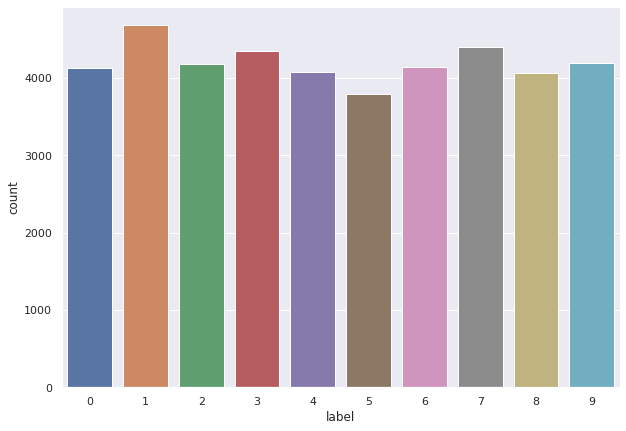

In [90]:
sns.set(rc={'figure.figsize':(10,7)})
sns.countplot(y_train)

In [ ]:
n_rows = X_train.shape[0] # .shape[0] pickup rows
print("n_rows:",n_rows)
n_cols = X_train.shape[1] # .shape[1] pickup columns
print("n_cols:", n_cols)

n_rows: 42000
n_cols: 784


## 2.2 Convert Dataset into Image Dataset and Visulize

In [91]:
# Reshape the data
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# Normalize data
X_train = X_train/255.0
X_test = X_test/255.0
X_train.shape, X_test.shape


((42000, 28, 28, 1), (28000, 28, 28, 1))

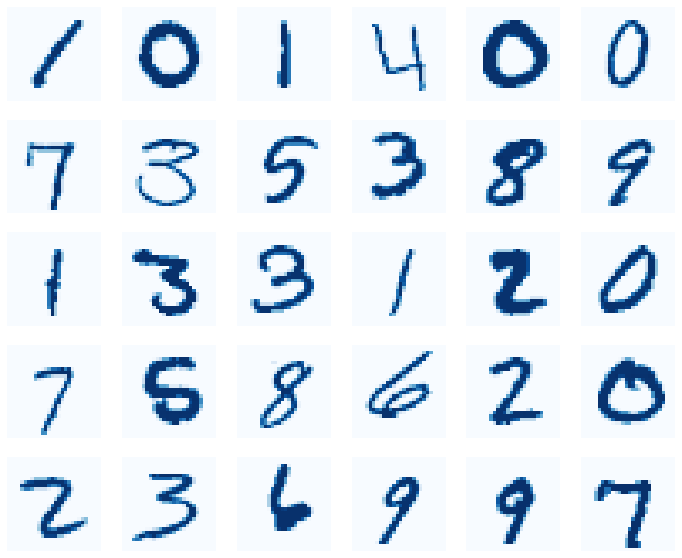

In [93]:
# Visulize data
rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(X_train[i].reshape([28,28]), cmap="Blues") 
    plt.axis("off")

## 2.3 Standarize Dataset

In [95]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_train.shape

(37800, 10)

## 2.4 Split Data into Training and Validation

In [96]:
# Generate images from dataset
from keras.preprocessing import image 
image_generator = image.ImageDataGenerator()
seed = 42
np.random.seed(seed)

# split training and validation dataset
from sklearn.model_selection import train_test_split
X = X_train
Y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =0.10, random_state = 42)

# Create training and validation batches
training_batch = image_generator.flow(X_train, y_train, batch_size = 64)
validation_batch = image_generator.flow(X_val, y_val, batch_size = 64)

In [97]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape) 
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (34020, 28, 28, 1)
X_val shape: (3780, 28, 28, 1)
y_train shape: (34020, 10)
y_val shape: (3780, 10)


# (3) Develop model and Train

## 3.1 Create TensorFlow Model
1. The kernel size does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
2. kernels detects features like edges or convex shapes. Example, if out input is digit image, feature detector can detect features like edges
3. feature map = conv(input image, feature detector). Element wise multiplication of matrices. feature map = convolved feature
4. We reduce the size of image. This is important bc code runs faster. However, we lost information.
5. We create multiple feature maps bc we use multiple feature detectors(filters).

In [100]:
# CNN

model = Sequential([
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.1),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax'),
])

## 3.2 Define optimizer
We will use "adam optimizer. We will definethe learning rate, after that, compile the model.

In [101]:
# optimizer 

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


## 3.3 Define Learning Rate

In [104]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.5, min_lr=0.00001)

## 3.4 Augment Data
To avoid the overfitting problem, it's necessary to expand artificially our handwritten digit dataset. By altering the training data with small transformations we are able to reproduce the variations occuring when someone is writing a digit.

Methods like the one described above that alter the training data in ways that change the array representation while keeping the label the same are known as "data augmentation" techniques. Some popular augmentations used are: grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and more.

In [105]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

## 3.5 Train and Fit Model
reference: https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

In [121]:
epochs = 35
batch_size = 90

history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/35
378/378 [==============================] - 8s 21ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.0334 - val_accuracy: 0.9968
Epoch 2/35
378/378 [==============================] - 8s 21ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.0345 - val_accuracy: 0.9942
Epoch 3/35
378/378 [==============================] - 8s 21ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0325 - val_accuracy: 0.9947
Epoch 4/35
378/378 [==============================] - 8s 21ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0283 - val_accuracy: 0.9944
Epoch 5/35
378/378 [==============================] - 8s 21ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0367 - val_accuracy: 0.9939
Epoch 6/35
378/378 [==============================] - 8s 21ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0342 - val_accuracy: 0.9942
Epoch 7/35
378/378 [==============================] - 8s 21ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0400 - val_accuracy: 0.9942

## 3.6 Plot Model Perforance 

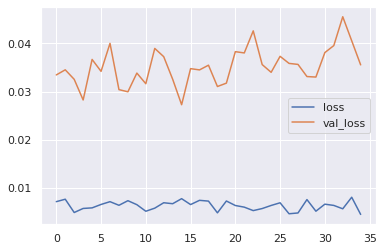

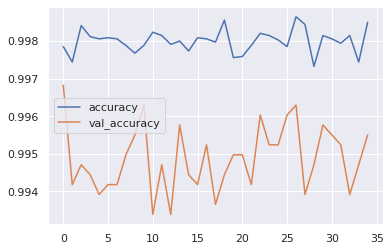

In [122]:
# Plot the loss and val_loss along with accuracy ans val_accuracy

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

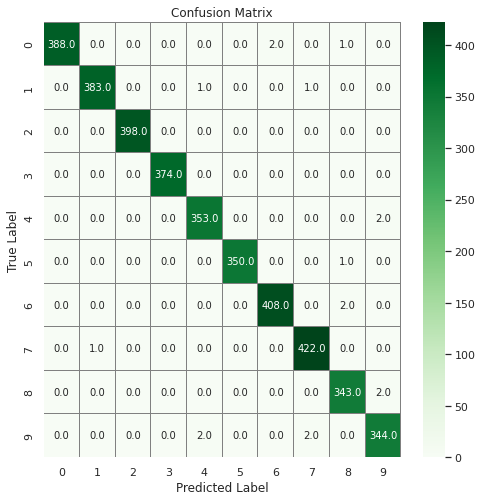

In [124]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3.7 Summary
it seems that our CNN has some troubles with the 4 digits, they are misclassified as 9. Sometimes it is very difficult to catch the difference between 4 and 9 when the person has a terrible handwriting. Our algorithm goes through the same problems we do.

Let's take a look at some errors we got

In [125]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

IndexError: ignored

## 3.7 Model Prediction and Submission

In [126]:
predictions = model.predict(X_test, batch_size=64)
image_id = range(1, predictions.shape[0] +1)

In [127]:
pred = [np.argmax(i) for i in predictions]

In [128]:
sample = pd.read_csv('/content/drive/MyDrive/nw_msdsp/nwds_fall_2021/422_Practical Machine Learning/mod6_digit_recognition/sample_submission.csv')
sample.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [129]:
submission = pd.DataFrame({'ImageId': image_id, 'Label': pred})
submission.to_csv('digit_recognition_tf_suthar', index=False)

In [130]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
